<a href="https://colab.research.google.com/github/torifinch/Tweet_Classification/blob/main/Disaster_Tweets_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

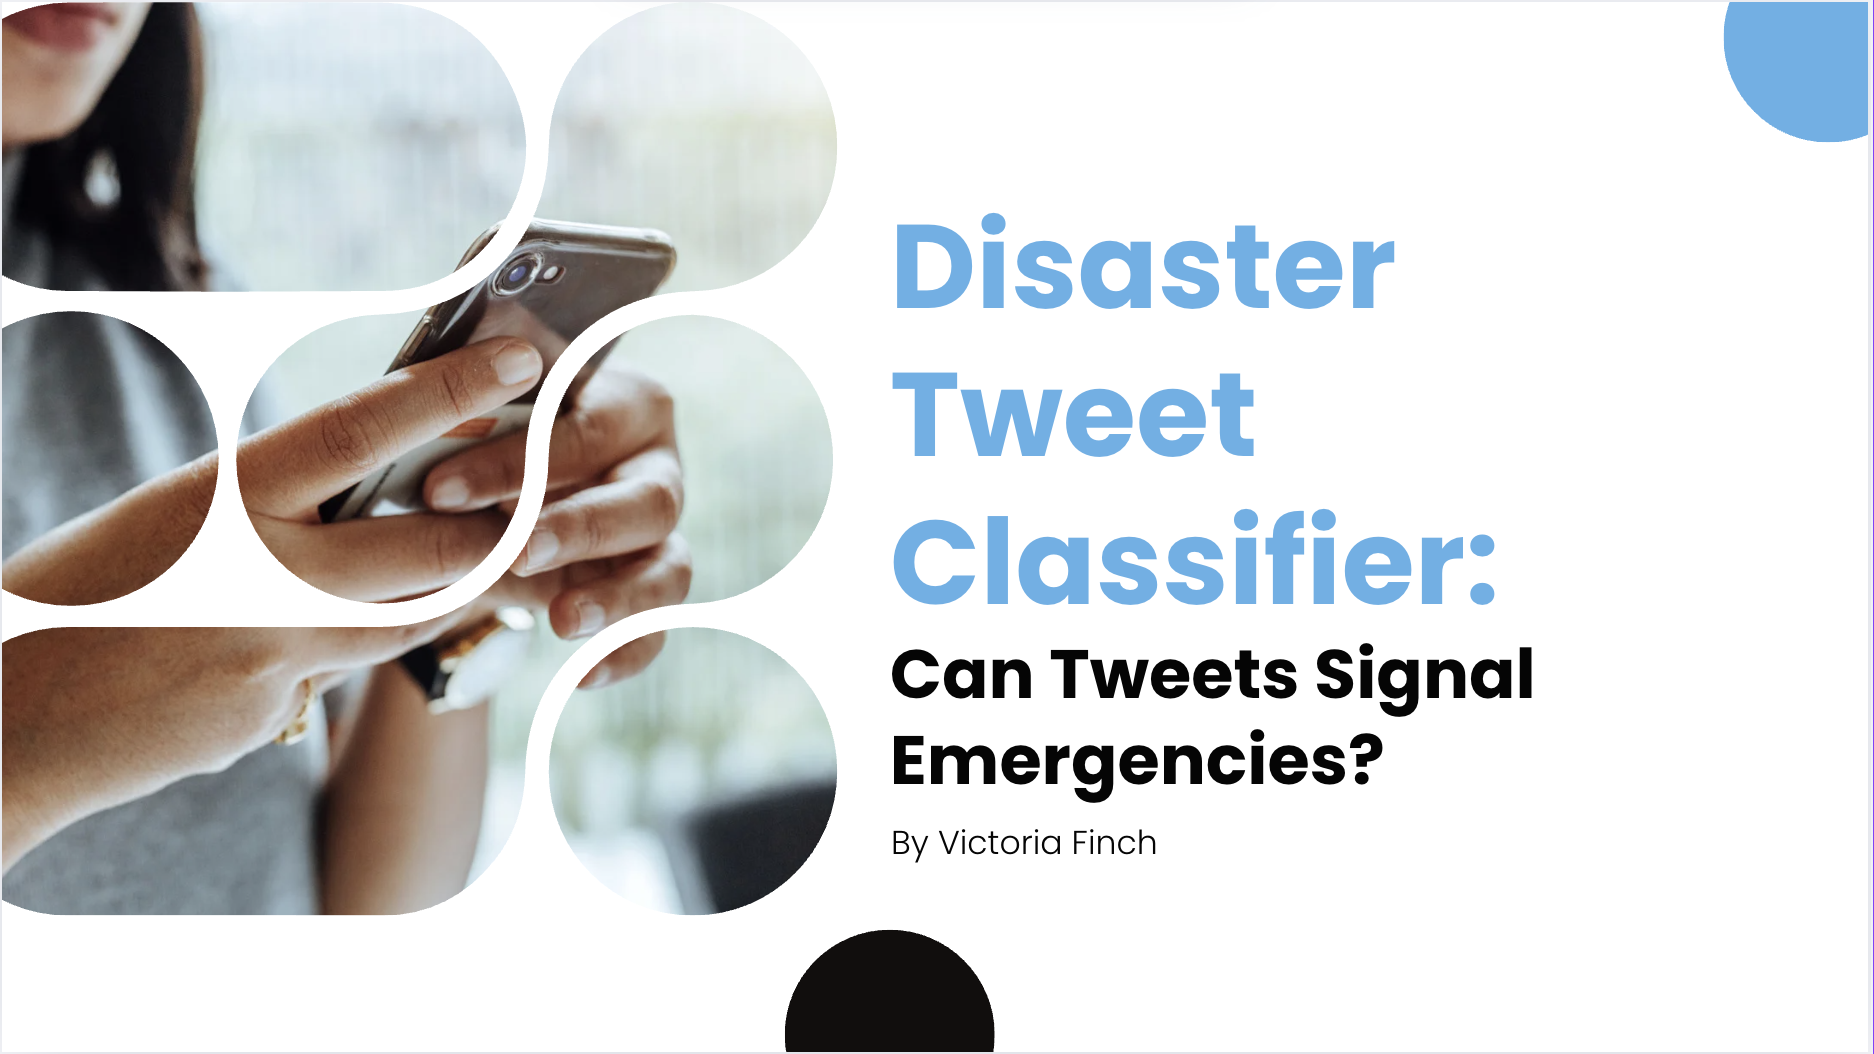

## Project: Disaster Tweet Binary Classifier
### Objective
Build a machine learning model to classify whether a tweet refers to a real disaster or not.

 Author: Victoria Finch

Date: 03.07.2025

Dataset source: [Kaggle - Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/competitions/)

---
### Steps
- Data cleaning (contractions, misspellings, tokenization, lemmatization)
- Feature engineering using TF-IDF
- Baseline models: Logistic Regression, Random Forest, XGBoost
- Hyperparameter tuning with GridSearchCV
- Model evaluation: accuracy, precision, recall, F1
- VotingClassifier ensemble
- Cross Validation Scores
---
Performance

I use several metrics to evaluate the models:

- **Precision** – "Of all the tweets predicted as disasters, how many actually were?"
  - High precision = **fewer false alarms**
  - Useful when we want to be **careful not to overreact**.

- **Recall** – "Of all the actual disaster tweets, how many did we correctly identify?"
  - High recall = **fewer missed disasters**
  - Crucial when **missing a real event is dangerous**.

- **F1 Score** – Harmonic mean of precision and recall.
  - Useful when we need a **balanced view of both accuracy and safety**.
  - Especially important in **imbalanced datasets**.

---

##  Models

- Logistic Regression (Baseline)
- Random Forest Classifier
- XGBoost Classifier  

### Best Model Performance
Logistic Regression
- Accuracy: 82%
- F1 Score (Disaster): 0.76



In [35]:
!pip install nltk

In [36]:
!pip install contractions

In [46]:
!wget http://luululu.com/tweet/typo-corpus-r1.txt -O doc3.txt

--2025-07-04 15:10:56--  http://luululu.com/tweet/typo-corpus-r1.txt
Resolving luululu.com (luululu.com)... 112.78.112.100, 2403:3a00:101:11:112:78:112:100
Connecting to luululu.com (luululu.com)|112.78.112.100|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://luululu.com/tweet/typo-corpus-r1.txt [following]
--2025-07-04 15:10:56--  https://luululu.com/tweet/typo-corpus-r1.txt
Connecting to luululu.com (luululu.com)|112.78.112.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2234636 (2.1M) [text/plain]
Saving to: ‘doc3.txt’

doc3.txt            100%[===================>]   2.13M   671KB/s    in 3.7s    

2025-07-04 15:11:01 (583 KB/s) - ‘doc3.txt’ saved [2234636/2234636]



In [37]:
# ===============================
# Import Libraries
# ===============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import Word

import re
import contractions
import unicodedata

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##Load Data

In [38]:
# ===============================
# Load Data
# ===============================

# Get Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Get Dataset from Google Drive to df
df = pd.read_csv('/content/drive/MyDrive/Datasets/disaster_tweets/train.csv')

df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


##EDA

In [40]:
# ===============================
# Explore Data
# ===============================

df

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [41]:
# Check for nulls
df.isnull().sum()

,0
text,0
target,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [43]:
# Count Targets
df['target'].value_counts()

,count
target,
0,4342
1,3271


In [44]:
# Count Targets by percent
(df['target'].value_counts() / len(df)) * 100

,count
target,
0,57.034021
1,42.965979


Slightly unbalanced, I will use Stratify.

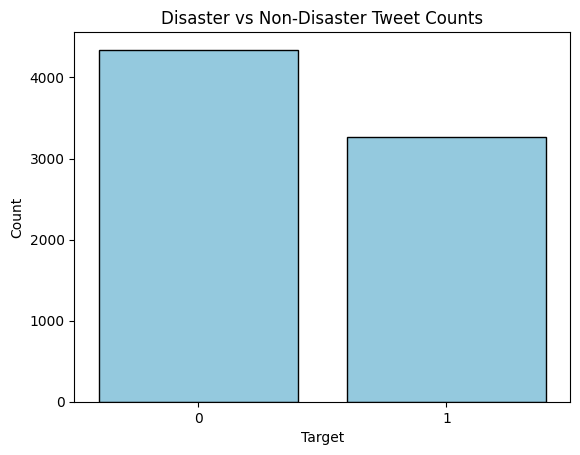

In [45]:
# Class distribution
sns.countplot(x='target', data=df, edgecolor='black', color='skyblue')
plt.title("Disaster vs Non-Disaster Tweet Counts")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

# Text Preprocessing

In [47]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
# ===============================
# Preprocess Text
# ===============================

# Load typo dictionary - Dico
dico = {}
with open('doc3.txt', 'rb') as file:
    for line in file:
        parts = line.decode('utf8').split()
        if len(parts) == 2:
            dico[parts[0]] = parts[1]

In [49]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

blacklist = {'us', 'is', 'it', 'he', 'she', 'no', 'on', 'in', 'am'}

# Clean typo dictionary
clean_dico = {k: v for k, v in dico.items() if k not in blacklist}

direction_map = {
    'n': 'north', 's': 'south', 'e': 'east', 'w': 'west',
    'ne': 'northeast', 'nw': 'northwest', 'se': 'southeast', 'sw': 'southwest',
    'km': 'kilometers', 'mi': 'miles', 'ft': 'feet', 'm': 'meters'
}


In [50]:
# Cleaning function
def clean_text(text, typo_dict=clean_dico):
    if not isinstance(text, str):
        return ""

    # Expand contractions
    text = contractions.fix(text)

    #Remove one letter words
    text = re.sub(r'\b[a-zA-Z]\b', '', text)

    # Normalize unicode
    text = unicodedata.normalize("NFKD", text)

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www.\S+", "", text)

    # Remove 'xx', 'xxx', etc.
    text = re.sub(r'\bxx+\b', '', text)

    # Separate digits and letters
    text = re.sub(r'(\d+)([a-zA-Z]+)', r'\1 \2', text)
    text = re.sub(r'([a-zA-Z]+)(\d+)', r'\1 \2', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize
    words = text.split()

    # Fix typos
    words = [typo_dict.get(word, word) for word in words]

    # Expand directional abbreviations if exact match
    words = [direction_map[word] if word in direction_map else word for word in words]

    # Remove stopwords and non-alpha tokens
    words = [word for word in words if word.isalpha() and word not in stop_words]

    #Lemmatize Words
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [51]:
df['clean_text'] = df['text'].apply(clean_text)

In [52]:
df['clean_text']

,clean_text
0,deed reason earthquake may allah forgive u
1,forest fire near la ronge sask canada
2,resident asked shelter place notified officer ...
3,people receive wildfire evacuation order calif...
4,got sent photo ruby alaska smoke wildfire pour...
...,...
7608,two giant crane holding bridge collapse nearby...
7609,thetawniest control wild fire california even ...
7610,meter kilometer volcano hawaii
7611,police investigating bike collided car little ...


###Train-Test Split

In [53]:
# ===============================
# Split Data
# ===============================

X = df['clean_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##Define and Tune Models

Pros of TfidfVectorizer:
 - Downweights very common words (like "the", "and")
 - Highlights rare, discriminative terms

Creating pipelines for my Models

tfidf: Converts the cleaned tweet text into a numerical format using term frequency, inverse document frequency.

clf: The XGBoost classifier, set to use logloss for binary classification and seeded for reproducibility.

In [54]:
# ===============================
# Define & Tune Models
# ===============================

# Logistic Regression
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
logreg_params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10]
}
logreg_search = GridSearchCV(logreg_pipeline, logreg_params, cv=3, scoring='f1', verbose=1)
logreg_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'clf__C': [0.1, 1, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=1)

In [55]:
# Random Forest
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])
rf_params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 20, 50]
}
#GridSearch
rf_search = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='f1', verbose=1)
rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__max_depth': [None, 20, 50],
                         'clf__n_estimators': [50, 100, 200],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=1)

In [56]:
# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier(eval_metric='logloss', random_state=42))
])
xgb_params = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.1, 0.3]
}
# Grid Search
xgb_search = GridSearchCV(xgb_pipeline, xgb_params, cv=3, scoring='f1', verbose=1)
xgb_search.fit(X_train, y_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_ty...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             param_grid={'clf__learning_rate': [0.1, 0.3],
                         'clf__max_depth': [3, 6],
                         'clf__n_estimators': [50, 100, 200],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=1)

## Evaluation

In [57]:
# ===============================
# Evaluate Best Models
# ===============================

models = {
    "Logistic Regression": logreg_search.best_estimator_,
    "Random Forest": rf_search.best_estimator_,
    "XGBoost": xgb_search.best_estimator_
}

for name, model in models.items():
    print(f"\n==== {name} ====")
    y_pred = model.predict(X_test)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


==== Logistic Regression ====
Confusion Matrix:
 [[739 130]
 [161 493]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       869
           1       0.79      0.75      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523


==== Random Forest ====
Confusion Matrix:
 [[749 120]
 [191 463]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       869
           1       0.79      0.71      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523


==== XGBoost ====
Confusion Matrix:
 [[755 114]
 [210 444]]
Classification Report:
               precision    recall  f1-score   support

           0      

#Results

###Logistic Regression
Logistic Regression remains a strong, balanced performer.
- Precision (0.79) and recall (0.75) for disasters indicate it catches most disaster tweets without overpredicting.
- Accuracy is solid at 81%, and both classes are handled relatively evenly.
- Great baseline choice—interpretable, fast, and reliable for this problem.

###Random Forest
Random Forest had similar overall accuracy (80%) but leaned slightly more toward false negatives.
- It had high precision for disasters (0.79), but slightly lower recall (0.71).
- It's a bit more complex than Logistic Regression without offering much gain.
- Good performance, but may not justify the added complexity in this case.

###XGBoost
XGBoost showed decent accuracy (79%) with slightly better disaster precision (0.80) than the others.
- However, recall dipped to 0.68, meaning more missed disasters compared to Logistic Regression.
- Still a competitive model and could shine with further hyperparameter tuning or a more balanced dataset.
- For now, it shows promise but slightly underperforms compared to the baseline in critical recall.



###Overall:
Logistic Regression offers the best balance between accuracy, precision, and recall.
- It's straightforward, performs well, and handles class predictions with consistency.
- For simplicity and effectiveness, it's your MVP model.
- Random Forest and XGBoost have potential, especially with more tuning—but didn’t significantly outperform.

###Ensemble Voting Classifier

In [58]:
# ===============================
# Ensemble Voting Classifier
# ===============================

voting_clf = VotingClassifier(
    estimators=[
        ('lr', logreg_search.best_estimator_),
        ('rf', rf_search.best_estimator_),
        ('xgb', xgb_search.best_estimator_)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
print("\n==== VotingClassifier Ensemble ====")
y_pred = voting_clf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


==== VotingClassifier Ensemble ====
Confusion Matrix:
 [[760 109]
 [180 474]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       869
           1       0.81      0.72      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



### Cross Validation Scores

In [27]:
# ===============================
# Cross-Validation
# ===============================

for name, search in [("LogReg", logreg_search), ("Random Forest", rf_search), ("XGBoost", xgb_search)]:
    scores = cross_val_score(search.best_estimator_, X, y, cv=5, scoring='f1')
    print(f"{name} Cross-Validation F1 Scores: {scores}")
    print(f"{name} Mean F1: {scores.mean():.4f} | Std: {scores.std():.4f}\n")

LogReg Cross-Validation F1 Scores: [0.30750308 0.38426966 0.32494279 0.34232122 0.50053476]
LogReg Mean F1: 0.3719 | Std: 0.0692

Random Forest Cross-Validation F1 Scores: [0.16111111 0.19160105 0.14419226 0.17438692 0.28534704]
Random Forest Mean F1: 0.1913 | Std: 0.0495

XGBoost Cross-Validation F1 Scores: [0.08417997 0.13204952 0.07386364 0.10982659 0.2294197 ]
XGBoost Mean F1: 0.1259 | Std: 0.0556



#  Cross-Validation Reaction:

Logistic Regression: While it performed best among the three models in CV, the F1 scores are quite low overall (mean ~0.37).
- This suggests that while the model looks solid on the test set, it struggles to generalize consistently across folds.
- One bright spot: it has the smallest standard deviation (±0.0692), so at least it's *consistently okay*.

Random Forest: Despite its strong accuracy on the test set, its mean F1 score here is just ~0.19.
-  The low scores indicate poor recall for the disaster class during validation — likely overfitting or imbalance issues.

XGBoost: This one really flopped during cross-validation (mean F1 ~0.13).
- It appears to be overfitting the training data, or it may be too sensitive to imbalances in the classes.

 Takeaway: Our models perform better on the holdout test set than they do across folds, which means:
- The test set might be easier than average (lucky split),
- Or we need better regularization, resampling, or feature selection.

#Next Steps:
- Try stratified CV to preserve class balance.
- Consider SMOTE or class weighting to handle imbalance.
- Tune vectorization settings (e.g. `min_df`, `max_df`) to reduce noise.


### ROC Curve

==== Logistic Regression ====
==== Random Forest ====
==== XGBoost ====


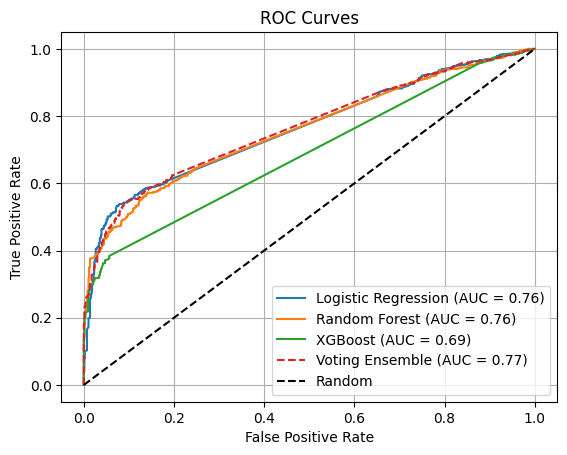

In [28]:
# ROC Curve

for name, model in models.items():
    print(f"==== {name} ====")
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

ensemble_proba = voting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Voting Ensemble (AUC = {auc_score:.2f})", linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)


In [ ]:
#

###Confusion Matrix Heatmap

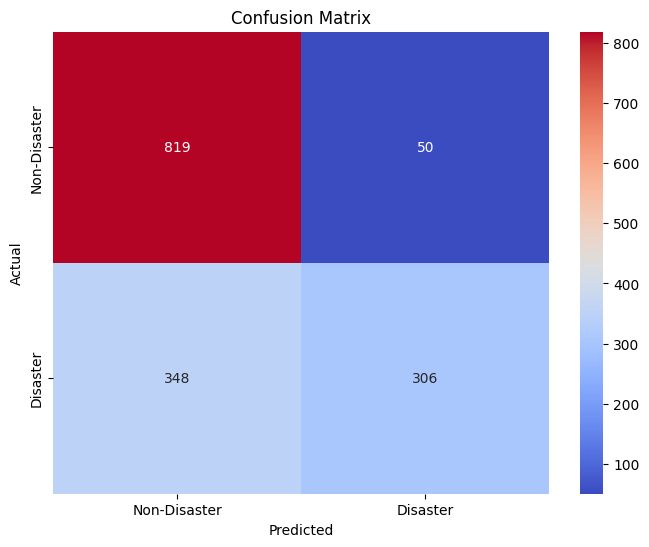

In [29]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

###Feature Importance (for TF-IDF + LogReg/XGB)

In [30]:
def show_top_features(pipeline, top_n=15):
    vectorizer = pipeline.named_steps['tfidf']
    classifier = pipeline.named_steps['clf']

    feature_names = vectorizer.get_feature_names_out()
    coefs = classifier.coef_[0]

    top_positive_features = np.argsort(coefs)[-top_n:]
    top_negative_features = np.argsort(coefs)[:top_n]
    top_features = np.concatenate((top_positive_features, top_negative_features))

    return feature_names, coefs


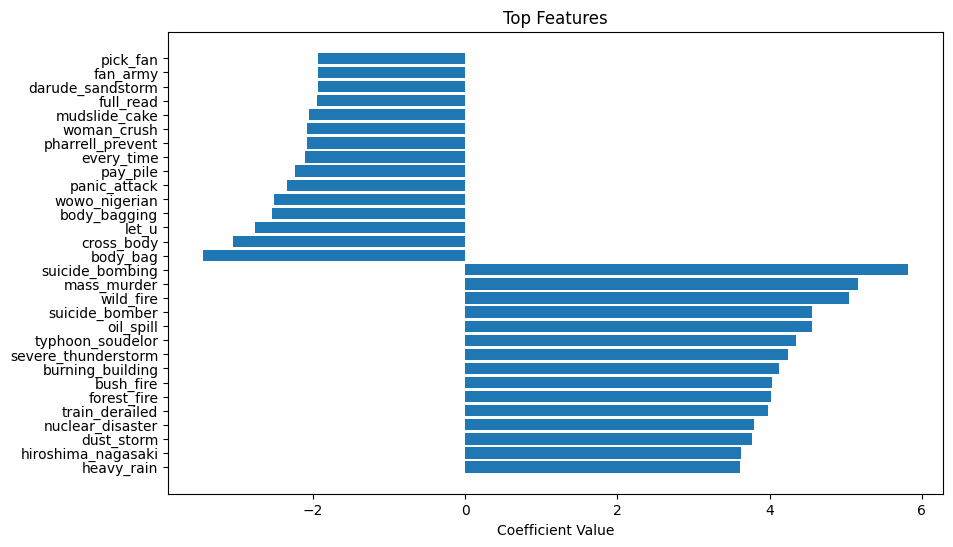

In [31]:
# Top Features Barchart
top_positive = np.argsort(logreg_search.best_estimator_.named_steps['clf'].coef_[0])[-15:]
top_negative = np.argsort(logreg_search.best_estimator_.named_steps['clf'].coef_[0])[:15]
top_features = np.concatenate((top_positive, top_negative))

plt.figure(figsize=(10, 6))
plt.barh(np.arange(2 * 15), logreg_search.best_estimator_.named_steps['clf'].coef_[0][top_features], align='center')

plt.yticks(np.arange(2 * 15), logreg_search.best_estimator_.named_steps['tfidf'].get_feature_names_out()[top_features])
plt.xlabel('Coefficient Value')
plt.title('Top Features')
plt.show()

### Disaster vs Non-Disaster Wordcloud

In [32]:
# Make wordcloud

df_cleaned_disaster = df[df['target'] == 1]
df_cleaned_not_disaster = df[df['target'] == 0]

df_cleaned_disaster_text = ' '.join(df_cleaned_disaster['clean_text'])
df_cleaned_not_disaster_text = ' '.join(df_cleaned_not_disaster['clean_text'])

Disaster Wordcloud

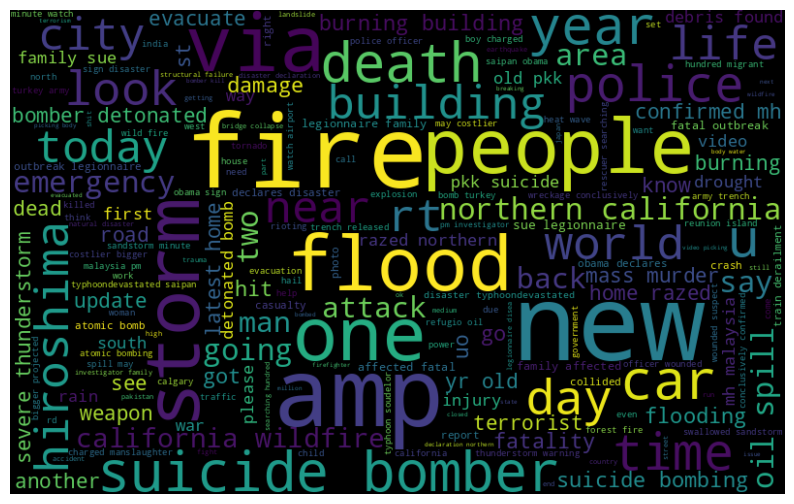

In [33]:
worldcloud = WordCloud(width = 800, height = 500,
                       random_state = 21,
                       max_font_size = 110).generate(df_cleaned_disaster_text)
plt.figure(figsize = (10,7))
plt.imshow(worldcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Non-Disaster Wordcloud

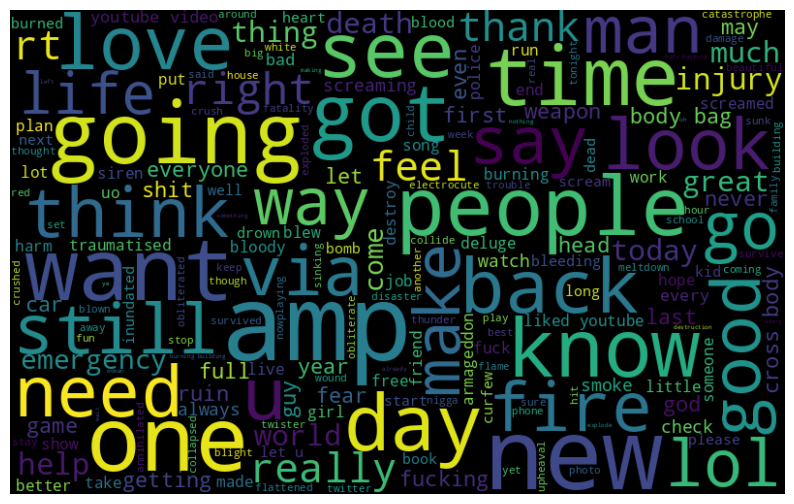

In [34]:
worldcloud = WordCloud(width = 800, height = 500,
                       random_state = 21,
                       max_font_size = 110).generate(df_cleaned_not_disaster_text)
plt.figure(figsize = (10,7))
plt.imshow(worldcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

#Final Thoughts
This project tackled a high-stakes problem: distinguishing real disaster-related tweets from irrelevant noise. Using a cleaned and lemmatized version of the tweet data, I explored and evaluated three popular machine learning models, Logistic Regression, Random Forest, and XGBoost, to classify tweets effectively.

###Key Insights:

Logistic Regression emerged as the most reliable model with the best balance of precision and recall. It’s fast, interpretable, and performs consistently well and a solid baseline.

The models are overfitting. They perform better on the test split than they do across multiple CV folds. That means they're not generalizing well, and tuning regularization, preprocessing, and model complexity will help.

###Next Steps:
- Feature engineering:
Try adding engineered features (tweet length, presence of keywords, emojis, hashtags)

- More robust preprocessing:
Try removing rare words or noisy features

- Lower TF-IDF dimensions
